In [1]:
## Imports
import random
import json
import torch

from classes import  CIFAKE_loader, CIFAKE_CNN
from test import test_model, score_preds, test_thresh_size
from train import get_files, train_model


with open('./config.json') as f:
    config = json.load(f)

src_dir = config['CIFAKE_dir']  # https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/data, Dec 11, 14:05

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <03BFC270-EF54-36FC-B102-371F5164D3C9> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load data

In [2]:
# load data
data = get_files(src_dir)
# Split data
trainfiles = data['train'][:int(len(data['train']))]
testfiles = data['test']

trainfiles[0]  # tuple of filepath + class as str
len(trainfiles), trainfiles[0]

(100000, ('../data/CIFAKE/train/REAL/1006 (3).jpg', 'REAL'))

In [3]:
# plot example pre/post normalise; cf tutorial code
# import matplotlib.pyplot as plt
# plt.imshow(np.array(Image.open(a.data[0][0])))  #normal img
# c = transform(Image.open(a.data[0][0]))  # post transform & re-normalise,,kind of
# c = c / 2 + 0.5     # unnormalize
# npimg = c.numpy()
# plt.imshow(np.transpose(npimg, (1, 2, 0)))
# plt.show()

In [12]:
traindata = CIFAKE_loader(trainfiles, batch_size=32)
testdata = CIFAKE_loader(testfiles, batch_size=32)

### Base model
Cifar10_tutorial.ipynb; mod for binary classification  
also very similar to structure decribed in Bird & Lotfi (2024)
'simple' CNN with FCN

CNN+Linear layers with maxpooling  
Conv2d(3, 6, 5),  
ReLU(),  
MaxPool2d(2, 2),  
Conv2d(6, 16, 5),  
ReLU(),  
MaxPool2d(2, 2),  
Flatten(),  
Linear(16 * 5 * 5, 120),
ReLU(),  
Linear(120, 84),  
ReLU(),  
Linear(84, 10)  
Sigmoid()  

In [ ]:
# init and train base model
basemodel = CIFAKE_CNN()
# default lr=0.001, momentum=0.9
basemodel = train_model(basemodel, traindata, epochs=10)


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 0	total loss: 1959.4076784849167	avg loss: 0.6270104571151733


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 1	total loss: 1210.1911251097918	avg loss: 0.3872611600351334


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 2	total loss: 946.6595897600055	avg loss: 0.30293106872320175


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 3	total loss: 822.5482753477991	avg loss: 0.2632154481112957


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 4	total loss: 761.8944788277149	avg loss: 0.24380623322486877


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 5	total loss: 717.1698254197836	avg loss: 0.22949434413433076


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 6	total loss: 690.9890873860568	avg loss: 0.22111650796353818


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 7	total loss: 665.0427917353809	avg loss: 0.21281369335532188


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 8	total loss: 642.3054744619876	avg loss: 0.20553775182783604


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 9	total loss: 627.8357380162925	avg loss: 0.2009074361652136
Finished Training


In [6]:
# save basemodel
torch.save(basemodel.state_dict(), "./base_model.pth")

### Testing base model

In [14]:
# predict labels
gold, preds = test_model(basemodel, testdata)
# evaluate with accuracy, precision, recall, f1-score
eval = score_preds(gold, preds, verbose=True)

  0%|          | 0/625 [00:00<?, ?it/s]

Performance
Accuracy: 91.39%
Precison: 88.43%
Recall: 95.23%
F1-Score: 91.70%


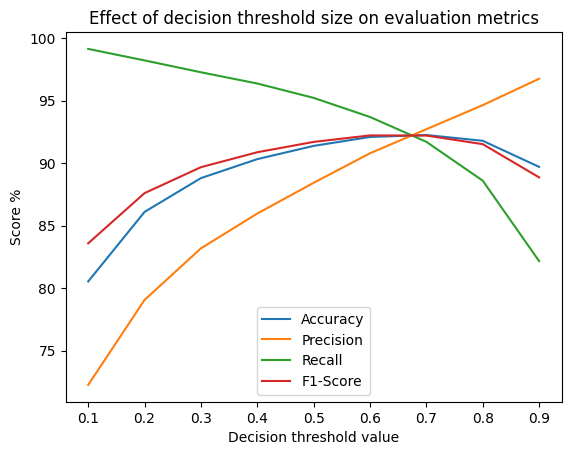

In [16]:
# explore effect of threshold size
import pandas as pd
import matplotlib.pyplot as plt

thresh_data = {}
for i in range(1, 10):
    thresh = round(i/10, 2)
    thresh_data[thresh] = {metric: score_preds(gold, preds, thresh=thresh)[i]
                           for i, metric in enumerate(['Accuracy', 'Precision',
                                                       'Recall', 'F1-Score'])}
base_thresh_df = pd.DataFrame(thresh_data.values(), index=thresh_data.keys()).mul(100)
fig = base_thresh_df.plot()

fig.set_ylabel('Score %')
fig.set_xlabel('Decision threshold value')
fig.title.set_text('Effect of decision threshold size on evaluation metrics')
fig.legend(loc='lower center')
plt.show()

In [23]:
# concrete values
base_thresh_df

,Accuracy,Precision,Recall,F1-Score
0.1,80.530,72.245701,99.15,83.586242
0.2,86.100,79.051988,98.23,87.603674
0.3,88.805,83.180847,97.28,89.679650
0.4,90.325,85.969137,96.38,90.877375
0.5,91.385,88.429752,95.23,91.703982
0.6,92.100,90.794574,93.70,92.224409
0.7,92.255,92.720655,91.71,92.212558
0.8,91.795,94.648008,88.60,91.524198
0.9,89.705,96.761277,82.16,88.864853


In [24]:
# meta data on threshold exploration
base_thresh_df.describe()

,Accuracy,Precision,Recall,F1-Score
count,9.000000,9.000000,9.000000,9.000000
mean,89.222222,87.089104,93.604444,89.808549
std,3.802999,7.900798,5.427046,2.823560
min,80.530000,72.245701,82.160000,83.586242
25%,88.805000,83.180847,91.710000,88.864853
50%,90.325000,88.429752,95.230000,90.877375
75%,91.795000,92.720655,97.280000,91.703982
max,92.255000,96.761277,99.150000,92.224409


In [38]:
# find peak for each metric
for x in zip([a for a in base_thresh_df.max().items()], base_thresh_df.idxmax()):
    print(x)

(('Accuracy', 92.255), 0.7)
(('Precision', 96.76127664586033), 0.9)
(('Recall', 99.15), 0.1)
(('F1-Score', 92.2244094488189), 0.6)


## SRM attention modified model

In [57]:
attn_model = CIFAKE_CNN(attn=True)
attn_model = train_model(attn_model, traindata, epochs=50)

  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 0	total loss: 2051.901435673237	avg loss: 0.6566084594154358


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 1	total loss: 1182.6698518544436	avg loss: 0.3784543525934219


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 2	total loss: 976.8979240059853	avg loss: 0.3126073356819153


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 3	total loss: 903.6183619648218	avg loss: 0.28915787582874297


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 4	total loss: 850.3439709097147	avg loss: 0.2721100706911087


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 5	total loss: 808.451560638845	avg loss: 0.2587044994044304


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 6	total loss: 774.3478025496006	avg loss: 0.2477912968158722


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 7	total loss: 744.0642739161849	avg loss: 0.23810056765317916


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 8	total loss: 721.3031662069261	avg loss: 0.23081701318621636


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 9	total loss: 693.9474975802004	avg loss: 0.22206319922566414


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 10	total loss: 676.551031909883	avg loss: 0.21649633021116257


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 11	total loss: 660.9757020249963	avg loss: 0.21151222464799882


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 12	total loss: 643.4875298831612	avg loss: 0.20591600956261158


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 13	total loss: 632.1983096674085	avg loss: 0.2023034590935707


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 14	total loss: 618.4781756922603	avg loss: 0.1979130162215233


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 15	total loss: 606.6718800961971	avg loss: 0.1941350016307831


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 16	total loss: 597.4828418642282	avg loss: 0.19119450939655305


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 17	total loss: 586.0423311758786	avg loss: 0.18753354597628116


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 18	total loss: 573.0536381471902	avg loss: 0.18337716420710087


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 19	total loss: 566.7178041692823	avg loss: 0.18134969733417033


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 20	total loss: 556.56336408481	avg loss: 0.1781002765071392


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 21	total loss: 545.7131561301649	avg loss: 0.17462820996165276


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 22	total loss: 539.823103537783	avg loss: 0.17274339313209056


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 23	total loss: 531.5936300698668	avg loss: 0.17010996162235736


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 24	total loss: 522.0117222620174	avg loss: 0.1670437511238456


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 25	total loss: 512.3307743482292	avg loss: 0.16394584779143334


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 26	total loss: 501.1638949289918	avg loss: 0.16037244637727738


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 27	total loss: 494.7495026458055	avg loss: 0.15831984084665776


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 28	total loss: 483.4758128840476	avg loss: 0.15471226012289524


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 29	total loss: 473.0144848804921	avg loss: 0.15136463516175747


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 30	total loss: 463.14967098739	avg loss: 0.1482078947159648


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 31	total loss: 453.66064136475325	avg loss: 0.14517140523672104


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 32	total loss: 447.63108899164945	avg loss: 0.14324194847732782


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 33	total loss: 432.0278500262648	avg loss: 0.13824891200840472


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 34	total loss: 422.8688068808988	avg loss: 0.1353180182018876


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 35	total loss: 412.39201354794204	avg loss: 0.13196544433534146


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 36	total loss: 401.4694883339107	avg loss: 0.12847023626685142


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 37	total loss: 390.20140098873526	avg loss: 0.12486444831639529


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 38	total loss: 379.5035319523886	avg loss: 0.12144113022476434


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 39	total loss: 370.1809638668783	avg loss: 0.11845790843740106


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 40	total loss: 358.23054391052574	avg loss: 0.11463377405136824


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 41	total loss: 348.3838732861914	avg loss: 0.11148283945158124


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 42	total loss: 339.8785132607445	avg loss: 0.10876112424343824


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 43	total loss: 324.86905227741227	avg loss: 0.10395809672877193


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 44	total loss: 314.5758432364091	avg loss: 0.10066426983565092


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 45	total loss: 304.19165354338475	avg loss: 0.09734132913388312


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 46	total loss: 296.45273588970304	avg loss: 0.09486487548470497


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 47	total loss: 284.76333056017756	avg loss: 0.09112426577925682


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 48	total loss: 274.1075084337499	avg loss: 0.08771440269879997


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 49	total loss: 269.3382839213591	avg loss: 0.08618825085483492
Finished Training


In [58]:
torch.save(attn_model.state_dict(), "./attn_model_50ep.pth")

In [ ]:
gold, preds = test_model(attn_model, testdata)
score_preds(gold, preds, verbose=True)

  0%|          | 0/625 [00:00<?, ?it/s]

Performance
Accuracy: 91.64%
Precison: 92.22%
Recall: 90.94%
F1-Score: 91.58%


(0.91635, 0.922218841902444, 0.9094, 0.915764563717839)

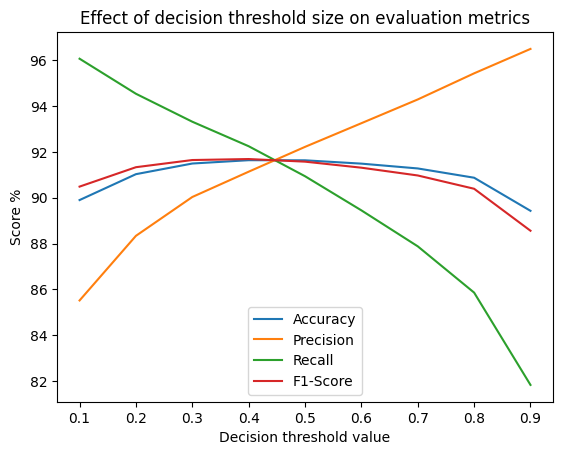

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

def test_thresh_size(gold, preds):

    thresh_data = {}
    for i in range(1, 10):
        thresh = round(i/10, 2)
        thresh_data[thresh] = {metric: score_preds(gold, preds, thresh=thresh)[i]
                            for i, metric in enumerate(['Accuracy', 'Precision',
                                                        'Recall', 'F1-Score'])}
    df = pd.DataFrame(thresh_data.values(), index=thresh_data.keys()).mul(100)

    return df

attn_df = test_thresh_size(gold, preds)

fig = attn_df.plot()

fig.set_ylabel('Score %')
fig.set_xlabel('Decision threshold value')
fig.title.set_text('Effect of decision threshold size on evaluation metrics')
fig.legend(loc='lower center')
plt.show()

In [67]:
attn_df

,Accuracy,Precision,Recall,F1-Score
0.1,89.900,85.517180,96.07,90.486955
0.2,91.030,88.338628,94.54,91.334171
0.3,91.495,90.033767,93.32,91.647434
0.4,91.640,91.138115,92.25,91.690687
0.5,91.635,92.221884,90.94,91.576456
0.6,91.490,93.254796,89.45,91.312781
0.7,91.280,94.291845,87.88,90.973085
0.8,90.875,95.431811,85.86,90.393220
0.9,89.430,96.497642,81.83,88.560606


In [68]:
attn_df.describe()

,Accuracy,Precision,Recall,F1-Score
count,9.000000,9.000000,9.000000,9.000000
mean,90.975000,91.858408,90.237778,90.886155
std,0.795468,3.513251,4.508347,0.993991
min,89.430000,85.517180,81.830000,88.560606
25%,90.875000,90.033767,87.880000,90.486955
50%,91.280000,92.221884,90.940000,91.312781
75%,91.495000,94.291845,93.320000,91.576456
max,91.640000,96.497642,96.070000,91.690687


In [69]:
# find peak for each metric
for x in zip([a for a in attn_df.max().items()], attn_df.idxmax()):
    print(x)

(('Accuracy', 91.64), 0.4)
(('Precision', 96.49764150943396), 0.9)
(('Recall', 96.07), 0.1)
(('F1-Score', 91.69068681045621), 0.4)


In [ ]:
# plot trainig acc vs val accuracy vs loss...

In [ ]:
# plot attention heat maps

In [ ]:
# run on CIFAR100

In [ ]:
# Apply on different test set